# Testing applying masks to the input data


In [1]:
import torch
import torchaudio
import torchaudio.transforms as T

In [2]:


def _get_sample(path, resample=None):
    effects = [["remix", "1"]]
    if resample:
        effects.extend(
            [
                ["lowpass", f"{resample // 2}"],
                ["rate", f"{resample}"],
            ]
        )
    return torchaudio.sox_effects.apply_effects_file(path, effects=effects)


def get_speech_sample(*, resample=None):
    return _get_sample(SAMPLE_WAV_SPEECH_PATH, resample=resample)


def get_spectrogram(
    n_fft=400,
    win_len=None,
    hop_len=None,
    power=2.0,
):
    waveform, _ = get_speech_sample()
    spectrogram = T.Spectrogram(
        n_fft=n_fft,
        win_length=win_len,
        hop_length=hop_len,
        center=True,
        pad_mode="reflect",
        power=power,
    )
    return spectrogram(waveform)


def plot_spectrogram2(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(spec), origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [1]:
import torch
#hyper parameters 
import torch.optim as optim
from model import get_accuracy
from model import *
from data_loading import resize_label
from data_loading import *
from torch.utils.data import DataLoader
from torchsummary import summary

epochs = 53
cutoff = 0.1 # using a really low one 
lr =0.01
batch_size = 4

#spectrogram parameters
spec_freq = 101
spec_time = 5511
#label time
label_time = 1375




#### Load data 

test_waveform = ReadData('test',spectrogram_str='False')
test = ReadData('test',spectrogram_str='True',number_frequencies = spec_freq,number_time_steps = spec_time)
train = ReadData('train',spectrogram_str='True',number_frequencies = spec_freq,number_time_steps = spec_time)

train_loader = DataLoader(train, batch_size, shuffle=False)
test_loader = DataLoader(test, batch_size, shuffle=False)





# Create custom time and frequency masking functions

In [ ]:
#create ReadDataMel - which normalises + time/frequency masks 


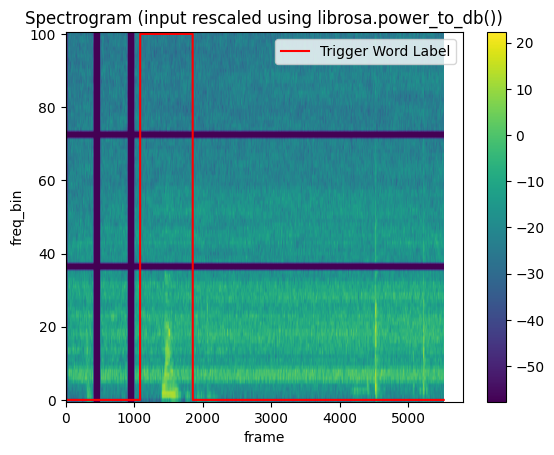

In [2]:
spec,labels_og = train[-1]



spec_mask, labels_new = mask_freq_time(spec, labels_og, t_l = 100, f_l = 2)
spec_mask2, labels_new = mask_freq_time(spec_mask, labels_og, t_l = 100, f_l = 2)


plot_spectrogram(spec_mask2[0],labels_new, title=None, ylabel='freq_bin', aspect='auto', xmax=None)
#plot_spectrogram2(spec_mask[0], title="Masked along time axis2")

In [286]:
# label_spec.squeeze(0).bool().nonzero().tolist()

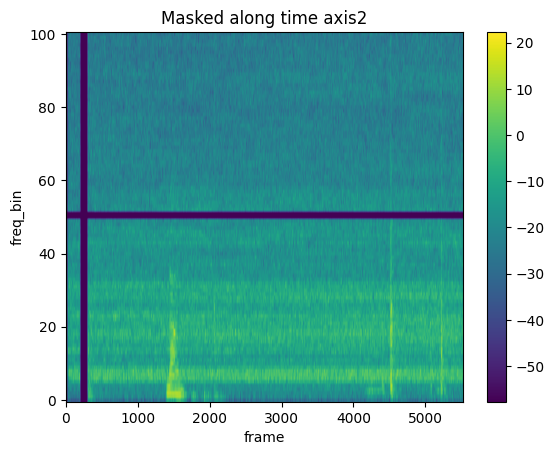

In [244]:
torch.random.manual_seed(4)

spec,label_spec = train[-1]
#plot_spectrogram2(spec[0], title="Original")

# masking = T.TimeMasking(time_mask_param = 1000, iid_masks = True, p = 0.1)
# #T.TimeMasking(time_mask_param=800)
# spec = masking(spec)
# spec = masking(spec)
# spec = masking(spec)
# spec = masking(spec)
# spec = masking(spec)

#this shouldn't clash with location of a trigger word 
t_s = 200
t_l = 100

#want frequency to be 10 off the bottom - that's the human range 
f_s = 50
f_l = 2

spec[:,:,t_s:t_s+t_l] = torch.zeros(t_l)
spec[:,f_s:f_s + f_l,:] = torch.zeros(f_l,spec.shape[-1])


plot_spectrogram2(spec[0], title="Masked along time axis2")

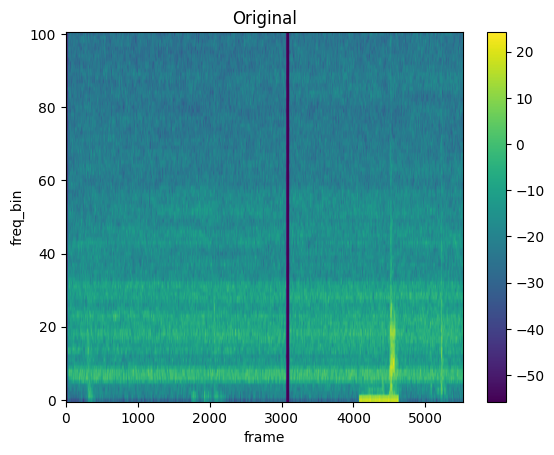

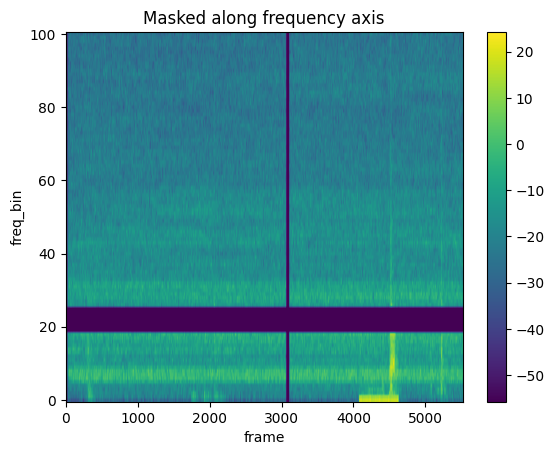

In [8]:

plot_spectrogram2(spec[0], title="Original")

masking = T.FrequencyMasking(freq_mask_param=80)
spec = masking(spec)

plot_spectrogram2(spec[0], title="Masked along frequency axis")

# Testing Mel spectrogram vs standard spectrogram 

In [122]:
test_Raw = ReadData('test',spectrogram_str='False',number_frequencies = spec_freq,number_time_steps = spec_time)

(wav,sam),label = test_Raw[-1]
#spec,label = train[-1]

In [149]:
n_fft = 200

spec_MEl = torchaudio.transforms.MelSpectrogram(sam,n_fft=n_fft,n_mels = 101, normalized=True)(wav)
spec_norm  = torchaudio.transforms.Spectrogram(n_fft=int(n_fft),normalized=True)(wav)
print(spec_MEl.shape, spec_norm.shape)

torch.Size([1, 101, 1601]) torch.Size([1, 101, 1601])


In [150]:
print(spec_MEl.shape,labels_new.shape)

torch.Size([1, 101, 1601]) torch.Size([1, 1001])


torch.Size([1, 160000]) torch.Size([1, 1601]) torch.Size([1, 101, 1601])


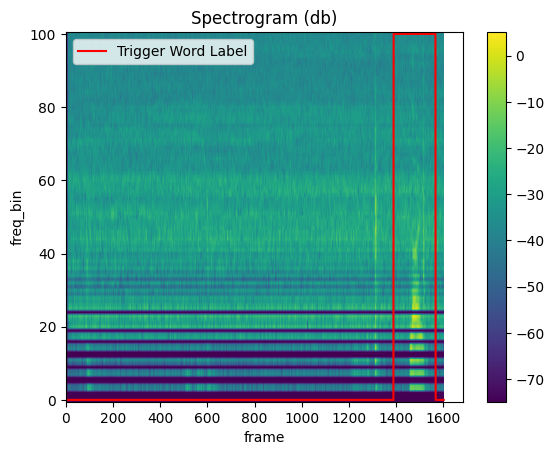

In [170]:

labels_new =  resize_label(label, spec_MEl.shape[2])

print(label.shape, labels_new.shape, spec_MEl.shape)

plot_spectrogram(spec_MEl[0],labels_new, title=None, ylabel='freq_bin', aspect='auto', xmax=None)

torch.Size([1, 160000]) torch.Size([1, 1601]) torch.Size([1, 101, 1601])


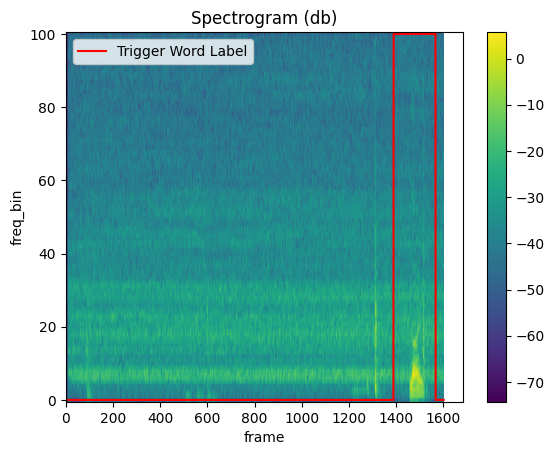

In [138]:
labels_new =  resize_label(label, spec_norm.shape[2])

print(label.shape, labels_new.shape, spec_norm.shape)


plot_spectrogram(spec_norm[0],labels_new, title=None, ylabel='freq_bin', aspect='auto', xmax=None)

In [145]:
print(torch.max(spec_MEl[0]))
torch.max(spec_norm)

tensor(3.2244)


tensor(3.7268)

# Normalise torch tensor